In [ ]:
!pip install pybind11
!pip install fastwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 213 kB 5.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for fastwer: filename=fastwer-0.1.3-cp37-cp37m-linux_x86_64.whl size=638476 sha256=b30199b87c80893de04293a7e04f817faa76708e9fce6ef45a92ed36096eb451
  Stored in directory: /root/.cache/pip/wheels/c8/b6/93/419e758f0c0176d311602763520bcfdec18107be1f15186fe6
Successfully built fastwer


In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path
from collections import Counter

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import fastwer
import pandas as pd

In [ ]:
!curl -LO https://github.com/AakashKumarNain/CaptchaCracker/raw/master/captcha_images_v2.zip
!unzip -qq captcha_images_v2.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100 8863k  100 8863k    0     0  12.4M      0 --:--:-- --:--:-- --:--:-- 12.4M


In [ ]:
# Path to the data directory
data_dir = Path("./captcha_images_v2/")

# Get list of all the images
images = sorted(list(map(str, list(data_dir.glob("*.png")))))
labels = [img.split(os.path.sep)[-1].split(".png")[0] for img in images]
characters = set(char for label in labels for char in label)

print("Number of images found: ", len(images))
print("Number of labels found: ", len(labels))
print("Number of unique characters: ", len(characters))
print("Characters present: ", characters)

# Batch size for training and validation
batch_size = 20

# Desired image dimensions
img_width = 200
img_height = 50

# Hence total downsampling factor would be 4.
downsample_factor = 4

# Maximum length of any captcha in the dataset
max_length = max([len(label) for label in labels])
print(max_length)

Number of images found:  1040
Number of labels found:  1040
Number of unique characters:  19
Characters present:  {'3', 'e', 'x', '5', 'n', 'p', '8', '7', 'm', '2', 'y', 'w', '6', 'f', 'g', 'd', 'b', '4', 'c'}
5


In [ ]:
# Mapping characters to integers
char_to_num = layers.StringLookup(
    vocabulary=list(characters), mask_token=None
)

# Mapping integers back to original characters
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

# Encoding

In [ ]:
def encode_single_sample(img_path, label):
    # 1. Read image
    img = tf.io.read_file(img_path)
    # 2. Decode and convert to grayscale
    img = tf.io.decode_png(img, channels=1)
    # 3. Convert to float32 in [0, 1] range
    img = tf.image.convert_image_dtype(img, tf.float32)
    # 4. Resize to the desired size
    img = tf.image.resize(img, [img_height, img_width])
    # 5. Transpose the image because we want the time
    # dimension to correspond to the width of the image. (200,50,1)
    img = tf.transpose(img, perm=[1, 0, 2])
    # 6. Map the characters in label to numbers
    label = char_to_num(tf.strings.unicode_split(label, input_encoding="UTF-8"))
    # 7. Return a dict as our model is expecting two inputs
    return {"image": img, "label": label}


# Split

In [ ]:
#Split 80/10/10. 
x_train = images[:832]
y_train = labels[:832]

x_val = images[832:936]
y_val = labels[832:936]

x_test = images[936:]
y_test = labels[936:]


train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = (train_dataset.map(encode_single_sample).batch(batch_size))

val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = (val_dataset.map(encode_single_sample).batch(batch_size))

test_dataset = tf.data.Dataset.from_tensor_slices((x_test, y_test))
test_dataset = (test_dataset.map(encode_single_sample).batch(batch_size))

# Build Model

In [ ]:
class CTCLayer(layers.Layer):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Compute the training-time loss value and add it
        # to the layer using `self.add_loss()`.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype="int64")
        input_length = tf.cast(tf.shape(y_pred)[1], dtype="int64")
        label_length = tf.cast(tf.shape(y_true)[1], dtype="int64")

        input_length = input_length * tf.ones(shape=(batch_len, 1), dtype="int64")
        label_length = label_length * tf.ones(shape=(batch_len, 1), dtype="int64")

        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)

        # At test time, just return the computed predictions
        return y_pred


def build_model():
    # Inputs to the model
    input_img = layers.Input(
        shape=(img_width, img_height, 1), name="image", dtype="float32"
    )
    labels = layers.Input(name="label", shape=(None,), dtype="float32")

    # First conv block
    x = layers.Conv2D(
        32, 
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv1",
    )(input_img)
    x = layers.MaxPooling2D((2, 2), name="pool1")(x)

    # Second conv block
    x = layers.Conv2D(
        64,
        (3, 3),
        activation="relu",
        kernel_initializer="he_normal",
        padding="same",
        name="Conv2",
    )(x)
    x = layers.MaxPooling2D((2, 2), name="pool2")(x)

    # We have used two max pool with pool size and strides 2.
    # Hence, downsampled feature maps are 4x smaller. The number of
    # Reshape w//pool*2,(h//pool*2)*conv_filter 
    new_shape = ((img_width // 4), (img_height // 4) * 64)
    x = layers.Reshape(target_shape=new_shape, name="reshape")(x)
    #Reducing Dimensional
    x = layers.Dense(64, activation="relu", name="dense1")(x)
    x = layers.Dropout(0.2)(x)

    # RNNs
    x = layers.Bidirectional(layers.LSTM(128, return_sequences=True, dropout=0.25))(x)
    x = layers.Bidirectional(layers.LSTM(64, return_sequences=True, dropout=0.25))(x)

    # Output layer
    x = layers.Dense(
        len(char_to_num.get_vocabulary()) + 1, activation="softmax", name="dense2"
    )(x)

    # Add CTC layer for calculating CTC loss at each step
    output = CTCLayer(name="ctc_loss")(labels, x)

    # Define the model
    model = keras.models.Model(
        inputs=[input_img, labels], outputs=output, name="ocr_model_v1"
    )
    # Optimizer
    opt = keras.optimizers.Adam()
    # Compile the model and return
    model.compile(optimizer=opt)
    return model


# Get the model
model = build_model()
model.summary()


Model: "ocr_model_v1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 image (InputLayer)             [(None, 200, 50, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 Conv1 (Conv2D)                 (None, 200, 50, 32)  320         ['image[0][0]']                  
                                                                                                  
 pool1 (MaxPooling2D)           (None, 100, 25, 32)  0           ['Conv1[0][0]']                  
                                                                                                  
 Conv2 (Conv2D)                 (None, 100, 25, 64)  18496       ['pool1[0][0]']       

# Training

In [ ]:
epochs = 100

# Train the model
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
)

Epoch 1/100
42/42 [==============================] - 37s 602ms/step - loss: 22.4080 - val_loss: 16.6770
Epoch 2/100
42/42 [==============================] - 35s 832ms/step - loss: 16.5454 - val_loss: 16.6645
Epoch 3/100
42/42 [==============================] - 23s 544ms/step - loss: 16.4952 - val_loss: 16.6572
Epoch 4/100
42/42 [==============================] - 21s 497ms/step - loss: 16.4643 - val_loss: 16.6805
Epoch 5/100
42/42 [==============================] - 21s 498ms/step - loss: 16.4389 - val_loss: 16.7032
Epoch 6/100
42/42 [==============================] - 20s 465ms/step - loss: 16.4022 - val_loss: 16.7863
Epoch 7/100
42/42 [==============================] - 19s 458ms/step - loss: 16.3682 - val_loss: 16.8551
Epoch 8/100
42/42 [==============================] - 19s 453ms/step - loss: 16.3363 - val_loss: 16.9403
Epoch 9/100
42/42 [==============================] - 19s 455ms/step - loss: 16.3039 - val_loss: 17.0048
Epoch 10/100
42/42 [==============================] - 19s 449ms/

# Predict

### Decoding

In [ ]:
# A utility function to decode the output of the network
def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    # Use greedy search. For complex tasks, you can use beam search
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0][
        :, :max_length
    ]
    # Iterate over the results and get back the text
    output_text = []
    for res in results:
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res)
    return output_text

In [ ]:
# Get the prediction model by extracting layers till the output layer
prediction_model = keras.models.Model(
    model.get_layer(name="image").input, model.get_layer(name="dense2").output
)
prediction_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 image (InputLayer)          [(None, 200, 50, 1)]      0         
                                                                 
 Conv1 (Conv2D)              (None, 200, 50, 32)       320       
                                                                 
 pool1 (MaxPooling2D)        (None, 100, 25, 32)       0         
                                                                 
 Conv2 (Conv2D)              (None, 100, 25, 64)       18496     
                                                                 
 pool2 (MaxPooling2D)        (None, 50, 12, 64)        0         
                                                                 
 reshape (Reshape)           (None, 50, 768)           0         
                                                                 
 dense1 (Dense)              (None, 50, 64)            49216 

In [ ]:
df_ = pd.DataFrame(columns = ['ocr_output'])
df__= pd.DataFrame(columns=['ref_text'])
for batch in val_dataset:
  batch_images = batch["image"]
  batch_labels = batch["label"]

  preds = prediction_model.predict(batch_images)
  pred_texts = decode_batch_predictions(preds)

  df1 = pd.DataFrame({'ocr_output':pred_texts})
  df_ = df_.append(df1,ignore_index = True)

  orig_texts = []
  for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)
  df2 = pd.DataFrame({'ref_text':orig_texts})
  df__ = df__.append(df2, ignore_index=True)
df_['ref_text'] = df__['ref_text']
df_

,ocr_output,ref_text
0,nxn4f,nxn4f
1,nxx25,nxx25
2,nxxf8,nxxf8
3,ny3dw,ny3dw
4,ny3nn,ny3nn
...,...,...
99,wxcn8,wxcn8
100,wxy4n,wxy4n
101,wyc25,wyc25
102,wye85,wye85


In [ ]:
l_cer = []
l_wer = []
for index, row in df_.iterrows():
  ref = row['ref_text']
  output = row['ocr_output']

  cer = fastwer.score_sent(output, ref, char_level=True)
  wer = fastwer.score_sent(output, ref, char_level=False)

  l_cer.append(round(cer,2))
  l_wer.append(round(wer,2))

a_cer = np.mean(np.array(l_cer))
a_wer = np.mean(np.array(l_wer))
print(f'Mean CER = {a_cer}%, Mean WER = {a_wer}%')


Mean CER = 0.19230769230769232%, Mean WER = 0.9615384615384616%


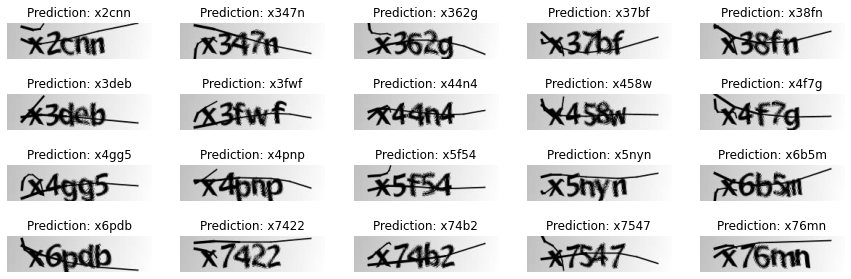

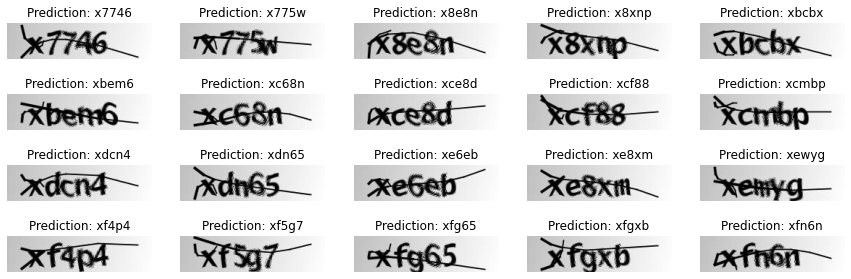

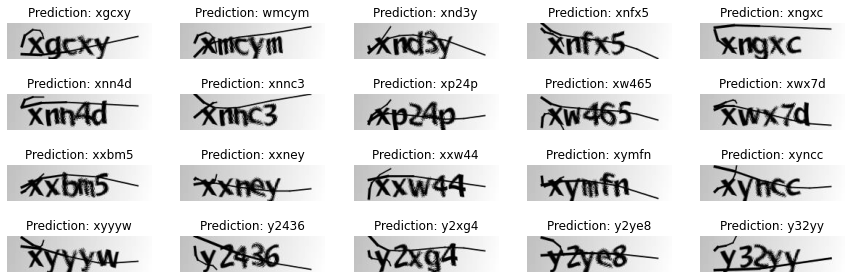

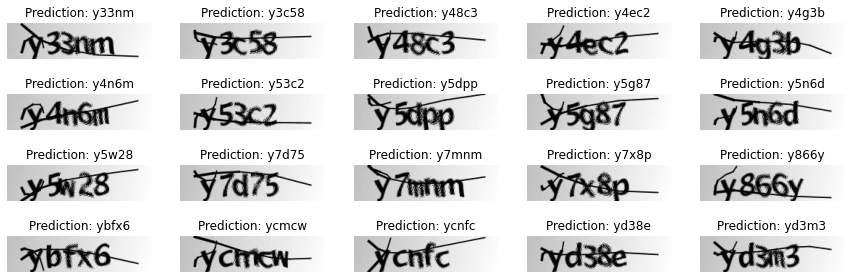

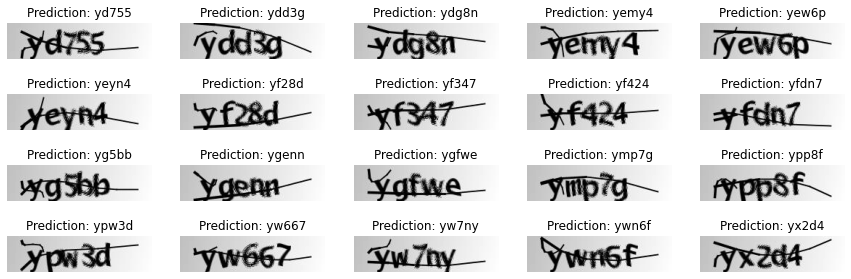

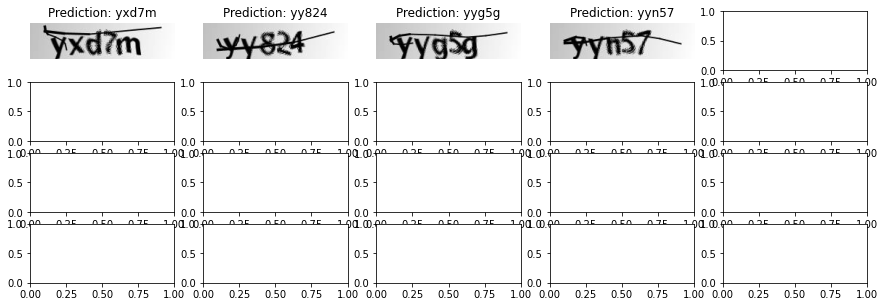

In [ ]:
for batch in test_dataset:
    batch_images = batch["image"]
    batch_labels = batch["label"]

    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)

    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(num_to_char(label)).numpy().decode("utf-8")
        orig_texts.append(label)

    _, ax = plt.subplots(4, 5, figsize=(15, 5))
    for i in range(len(pred_texts)):
        img = (batch_images[i, :, :, 0] * 255).numpy().astype(np.uint8)
        img = img.T
        title = f"Prediction: {pred_texts[i]}"
        ax[i // 5, i % 5].imshow(img, cmap="gray")
        ax[i // 5, i % 5].set_title(title)
        ax[i // 5, i % 5].axis("off")
plt.show()